# House Prices

Here, we're going to explore the kaggle House Price dataset and try to make a prediction model using random forest. (Spoiler: the predction model failed)

Dataset can be obtained <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques" target="_blank">here</a>.

On this repository, there's a .txt file which contains details about the dataset. Since it's a bit long, I won't be putting it here.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Data

At first, let's look how our data is structured.

In [2]:
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Now, let's see how many values are missing.

In [3]:
total_nan = data.isna().sum().sort_values(ascending = False)
percent_nan = (data.isna().sum()/data.isna().count()).sort_values(ascending = False)
data_type = data.dtypes

data_nan_info = pd.concat([total_nan, percent_nan, data_type], axis=1, keys=['Total', 'Percent', 'Type'])
data_nan_info.head(25)

,Total,Percent,Type
PoolQC,1453,0.995205,object
MiscFeature,1406,0.963014,object
Alley,1369,0.937671,object
Fence,1179,0.807534,object
FireplaceQu,690,0.472603,object
LotFrontage,259,0.177397,float64
GarageYrBlt,81,0.055479,float64
GarageCond,81,0.055479,object
GarageType,81,0.055479,object
GarageFinish,81,0.055479,object


As we can see, some columns pretty much doesn't have any data. We're going to deal with them later. For now, we're just going to delete the Id column, since it's not useful here.

In [4]:
data.drop('Id', axis = 'columns', inplace = True)

Now, we're going to group our column names by data type. We'll have numerical variables, which is subdivided into discrete and continuous, and categorical values. This is useful for us to analyze each type of data in a specific way.

In [5]:
num_var = [name for name in data if data[name].dtypes != 'object']
cat_var = [name for name in data if data[name].dtypes == 'object']
print(f'Categorical: {len(cat_var)}, Numerical: {len(num_var)}, Total: {len(cat_var)+len(num_var)}')

Categorical: 43, Numerical: 37, Total: 80


In [6]:
discrete_var = [name for name in num_var if len(data[name].unique())<25 ]
continuous_var = [name for name in num_var if len(data[name].unique())>=25 ]
print(f'Discrete: {len(discrete_var)}, continuous: {len(continuous_var)}, total: {len(num_var)}')

Discrete: 18, continuous: 19, total: 37


## Numerical Data Distibution

With our list of numerical variables, we can now plot them to see how they behave. We'll plot first the continuous ones, then the discrete ones. Is important to note that the distinction between continuous and discrete, here, was made by the amount of distinct values, however the possibily of a mistaken classification doesn't have a significant impact, since the visualization is very similar for them.

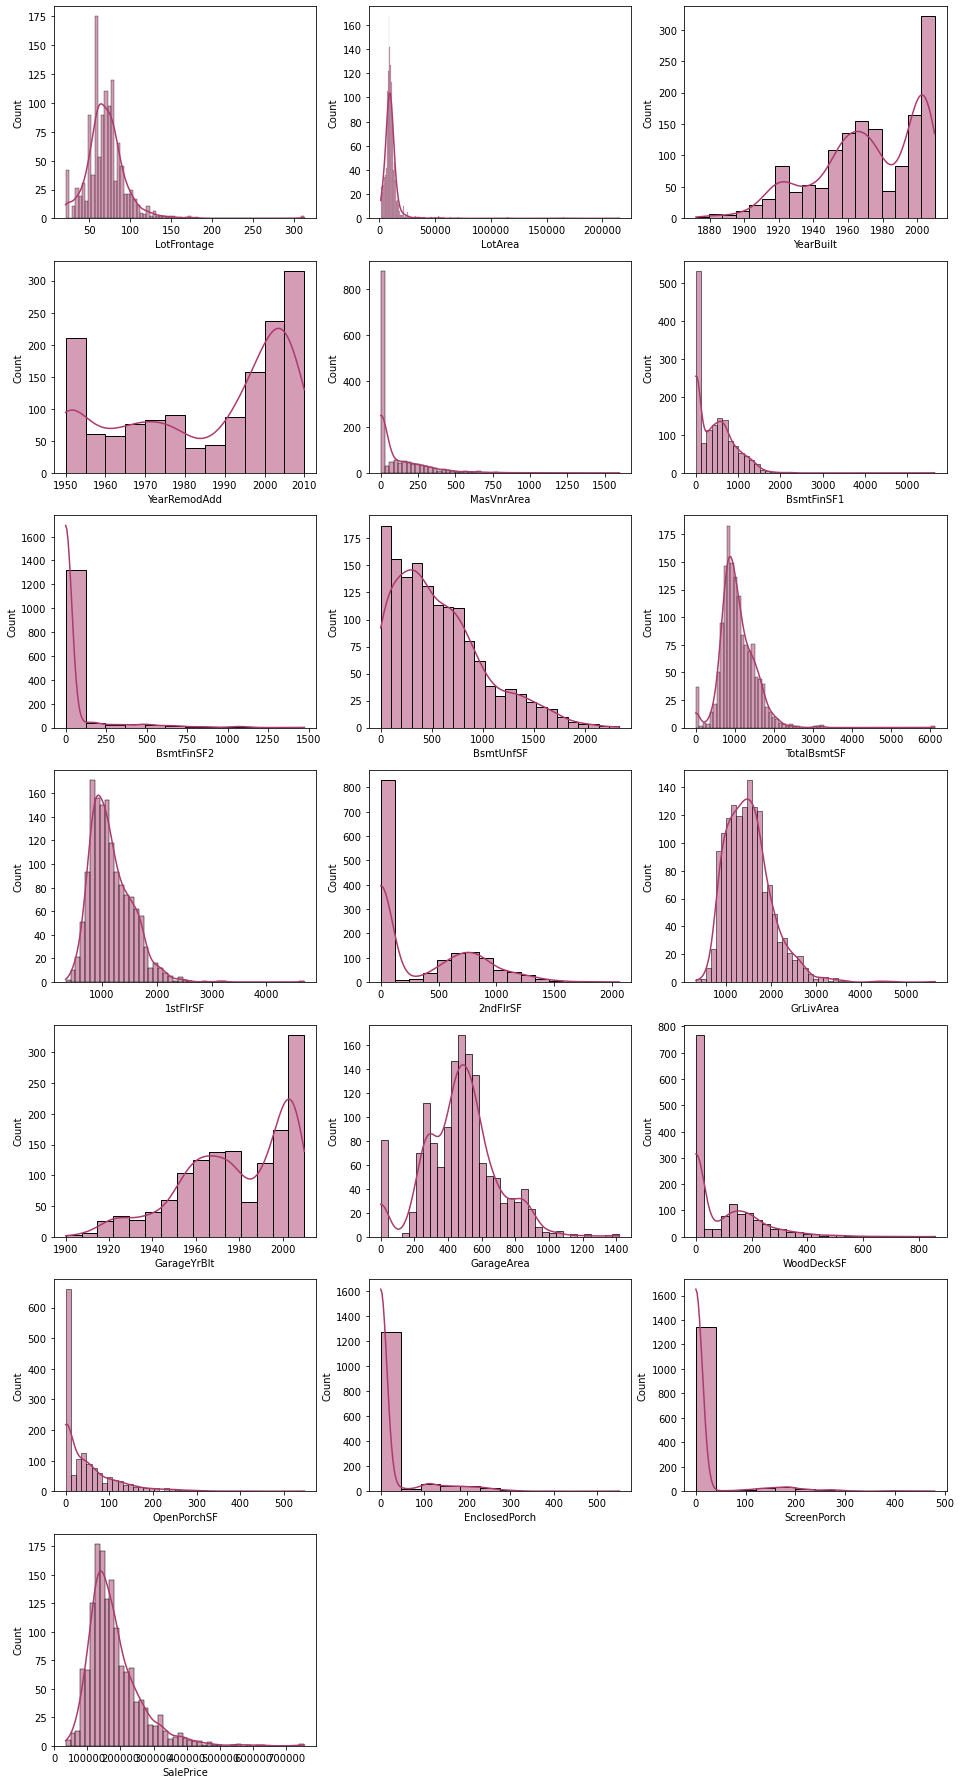

In [8]:
j=1
fig = plt.figure(figsize = (16,32))
#plt.subplots_adjust(hspace=0.5)
color = '#AB3A6D'
for i in continuous_var:
    plt.subplot(7,3,j)
    sns.histplot(x=data[i], kde=True, color=color) 
    j = j+1

Here we can see how a lot of the variables have mostly 0, which probably make them useless for our prediction model. We can also see that some of the data have almost a normal distribution, which might be obtained with a log transformation.

Now let's look at our discrete variables.

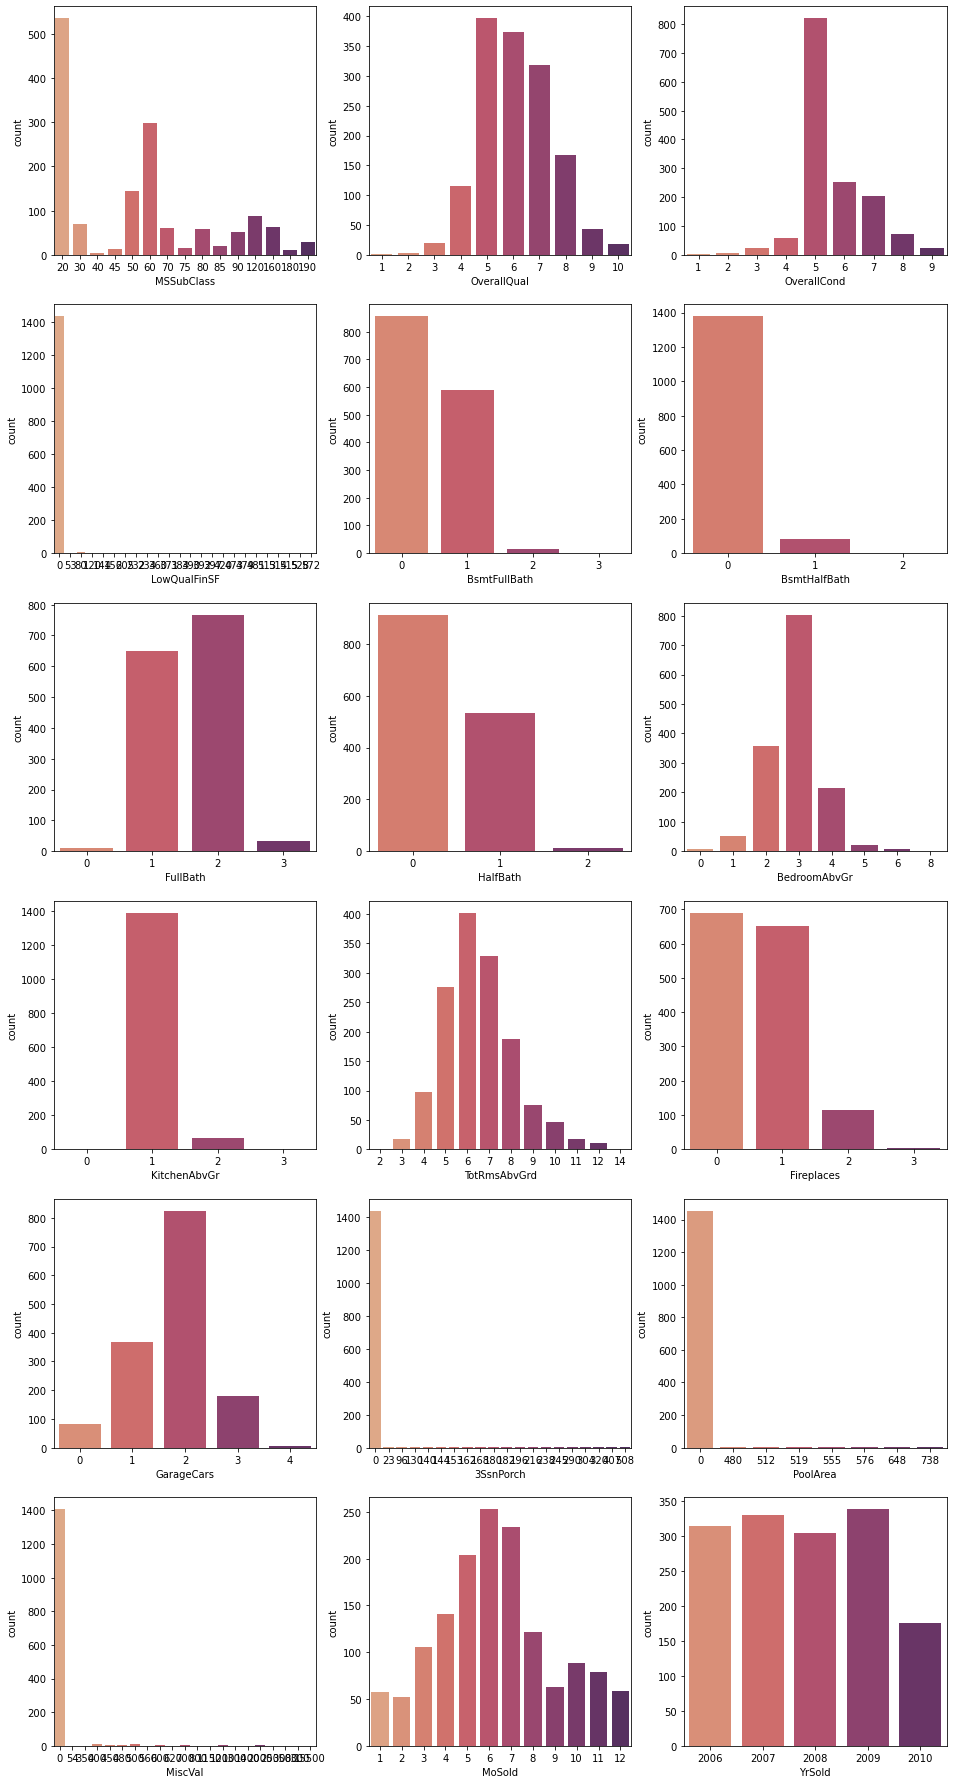

In [9]:
j=1
fig = plt.figure(figsize = (16,32))
for i in discrete_var:
    plt.subplot(6,3,j)
    sns.countplot(x=i, data=data, palette='flare')
    j=j+1

Once again, some have too much zeros. But there's also a lot of useful information here, like with MoSold (month sold) and OverallQual (overall quality), which show us a peak at a specific value range.

## Outliers

Here we're look at our quartiles and outliers for each of our continuous variable using boxplot.

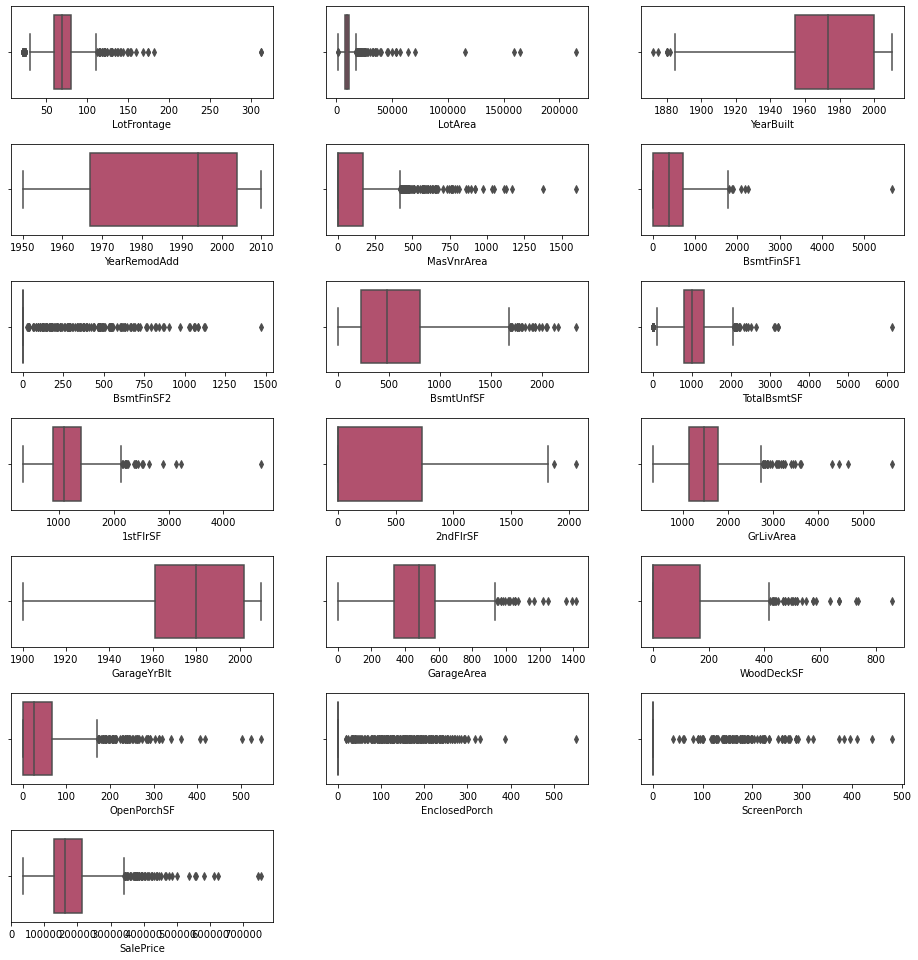

In [10]:
j=1
fig = plt.figure(figsize = (16,32))
plt.subplots_adjust(hspace = 0.5)
for i in continuous_var:
    plt.subplot(13,3,j)
    sns.boxplot(x=i, data = data, palette='flare')
    j=j+1

We  can see again that some variables are pretty much zero for most rows. Overall, there's a lot of outliers in most of the variables. For now, we're not going to do anything with them, but we might need to, in order to improve our prediction model.

## Correlation of Numerical Variables with Sale Price

Here we have our correlation coefficient betewn Sale Price and all the other numerical data. 

In [11]:
price_corr = pd.DataFrame(data.corr()['SalePrice'],index = data.select_dtypes(include=np.number).columns)
price_corr = price_corr.rename(columns={'SalePrice':'CorrCoef'})
price_corr

,CorrCoef
MSSubClass,-0.084284
LotFrontage,0.351799
LotArea,0.263843
OverallQual,0.790982
OverallCond,-0.077856
YearBuilt,0.522897
YearRemodAdd,0.507101
MasVnrArea,0.477493
BsmtFinSF1,0.386420
BsmtFinSF2,-0.011378


To make it prettier, let's make a heatmap with these coefficients, but instead of the usual one, that gives us correlation between everything, we'll limit it to Sale Price correlations only.

Text(0.5, 1.0, 'Correlation between SalePrice and the other Variables \n')

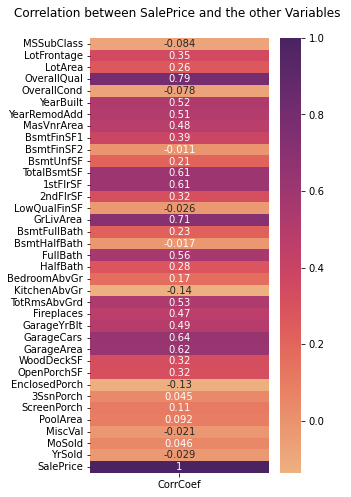

In [13]:
plt.figure(figsize = (4,8))
sns.heatmap(price_corr, annot=True, cmap='flare')
plt.title('Correlation between SalePrice and the other Variables \n', fontsize = 12)

We can also observe correlation through plots, we can't specify how much correlation there is, but we can observe the behavior between our variables.

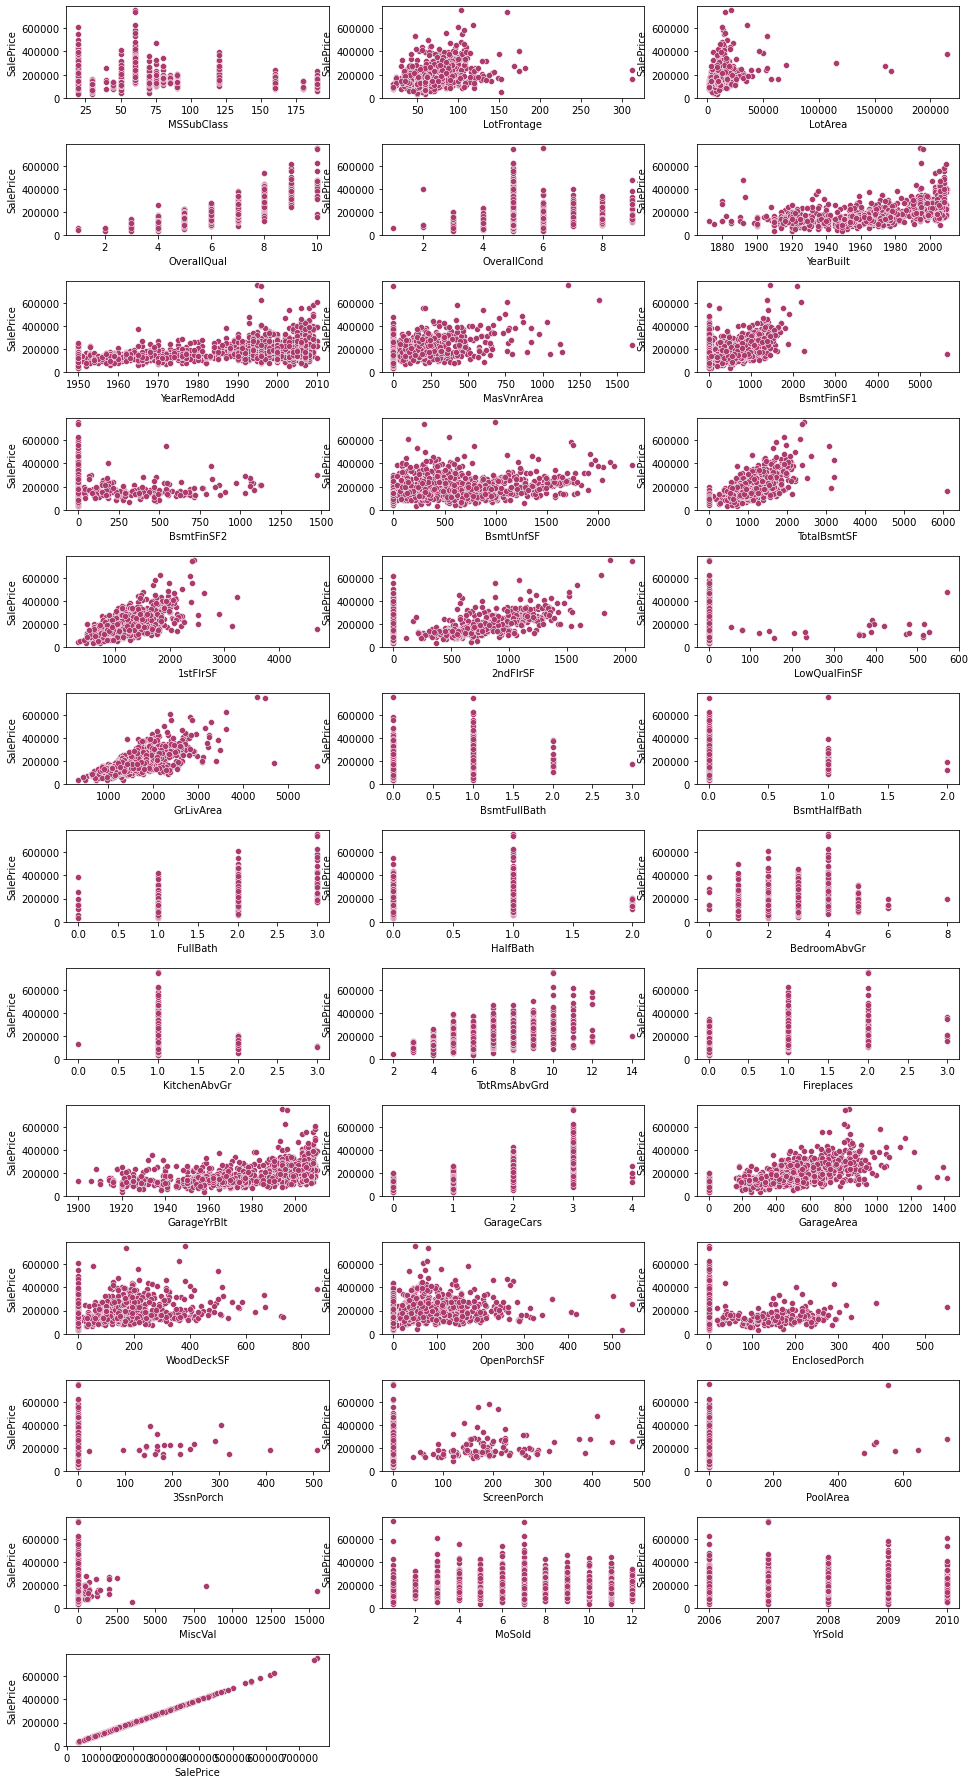

In [12]:
j=1
plt.figure(1, figsize=(16,32))
plt.subplots_adjust(hspace=0.5)
for i in num_var:
    plt.subplot(13,3,j)
    sns.scatterplot(x=i, y='SalePrice', data=data, color=color)
    j=j+1

## Correlation of Categorical Variables with Sale Price

Now that we finished exploring our numerical variables, let's dive in our categorical ones. Here, we'll use the median Sale Price that each distinct categorical value have.

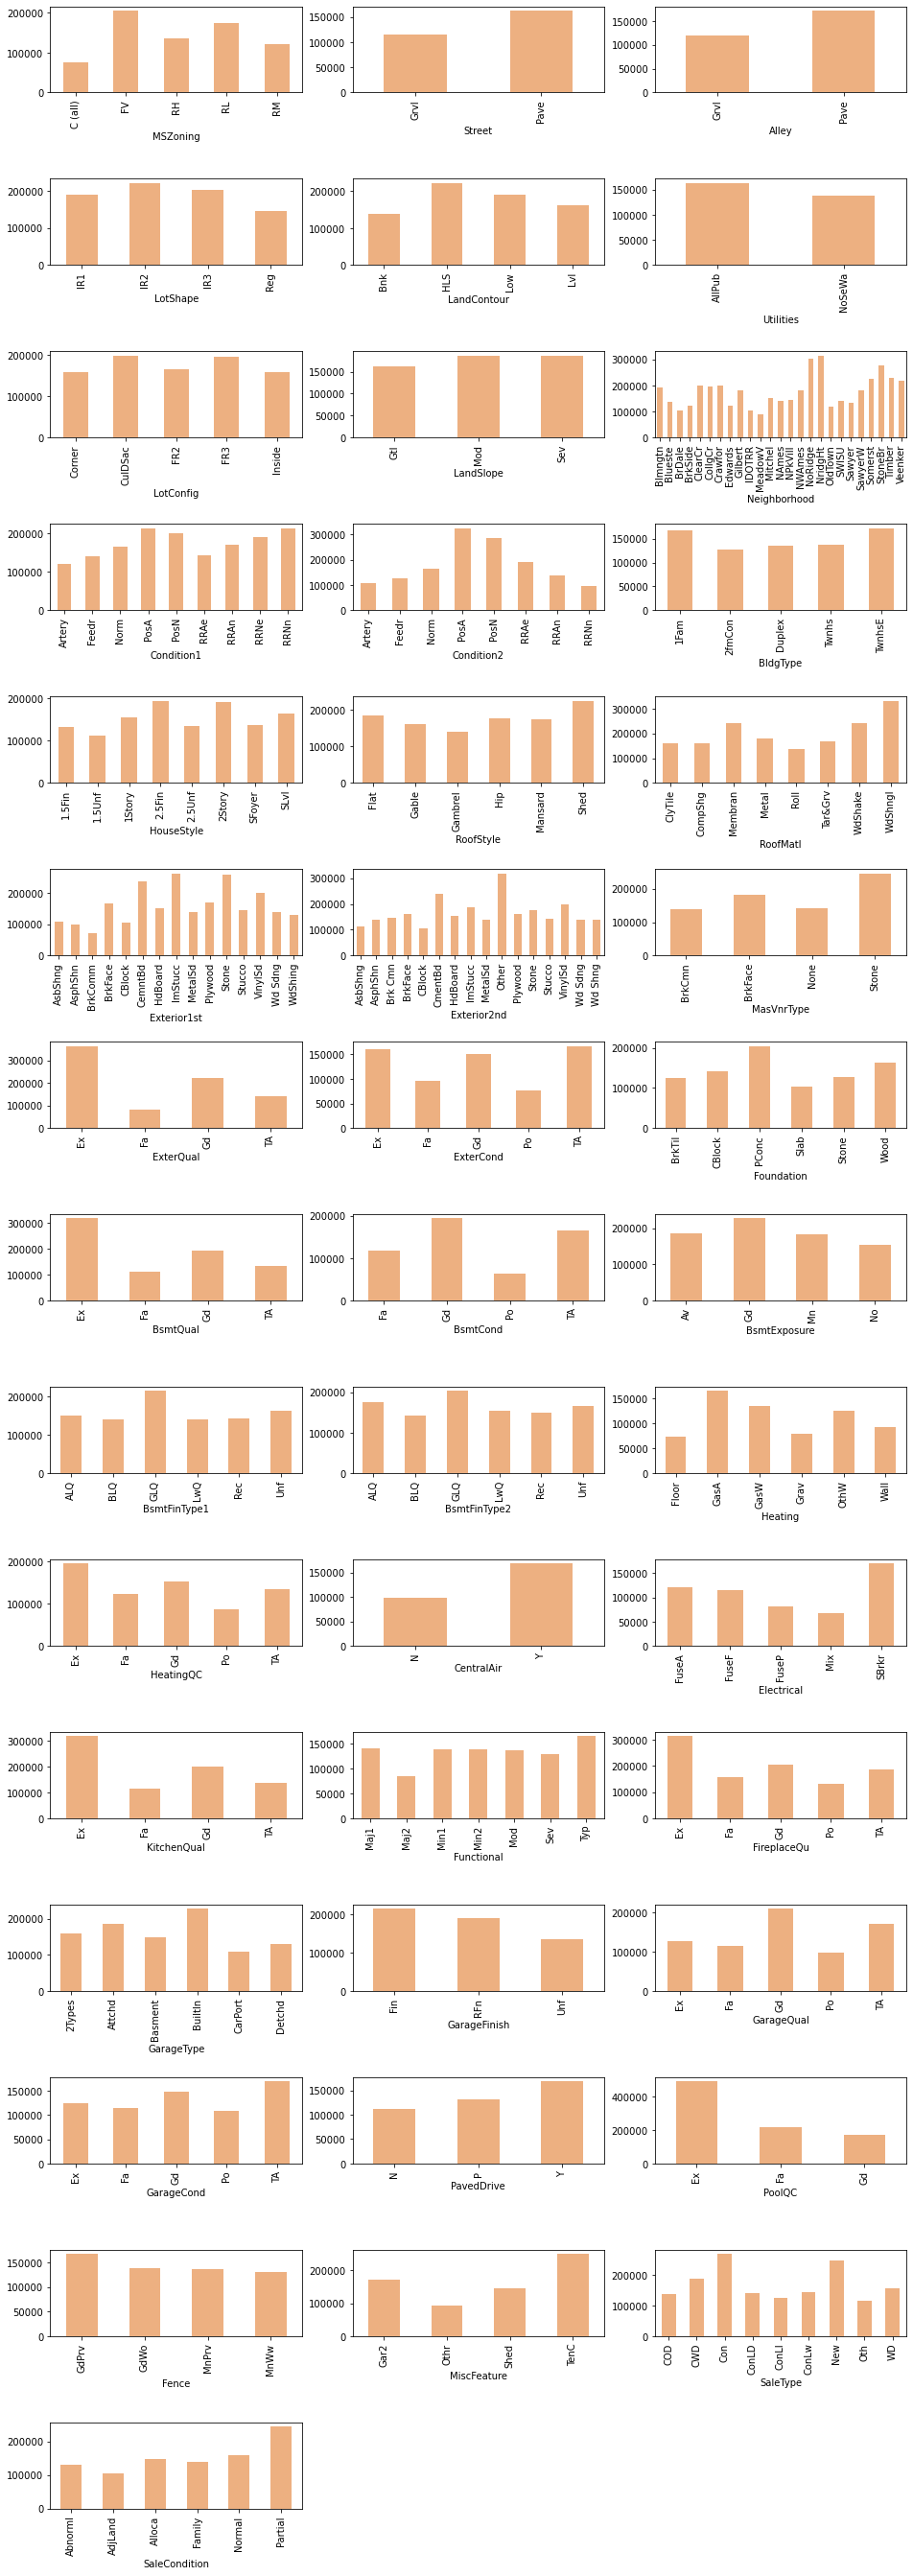

In [14]:
j=1
plt.figure(figsize=(16,48))
plt.subplots_adjust(hspace=1)
for i in cat_var:
    plt.subplot(15,3,j)
    data.groupby(i)['SalePrice'].median().plot.bar(colormap='flare')
    j=j+1

## Data Treatment

Now, let's deal with our missing values.

For columns with more than 15% of missing values, we'll simply delete them. 

In [15]:
nan_titles = data_nan_info.loc[(data_nan_info.Percent > 0.15)].index
nan_titles

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'LotFrontage'],
      dtype='object')

In [16]:
data.drop(nan_titles, axis = 'columns', inplace = True)

For other columns with missing values, we'll replace them with the median, for numerical, and the most frequent value, for categorical.

In [17]:
data.fillna(data.select_dtypes(include='number').median().iloc[0], inplace=True)
data.fillna(data.select_dtypes(include='object').value_counts().iloc[0], inplace=True)

Let's check if everything was replaced.

In [18]:
total_nan = data.isna().sum().sort_values(ascending = False)
percent_nan = (data.isna().sum()/data.isna().count()).sort_values(ascending = False)

data_nan_info = pd.concat([total_nan, percent_nan, data.dtypes], axis=1, keys=['Total', 'Percent', 'Type'])
data_nan_info.head(25)

,Total,Percent,Type
MSSubClass,0,0.0,int64
GarageYrBlt,0,0.0,float64
Fireplaces,0,0.0,int64
Functional,0,0.0,object
TotRmsAbvGrd,0,0.0,int64
KitchenQual,0,0.0,object
KitchenAbvGr,0,0.0,int64
BedroomAbvGr,0,0.0,int64
HalfBath,0,0.0,int64
FullBath,0,0.0,int64


## Regression with Random Forest

Here is where everything went wrong. I'll talk more about it on conclusions. But first, let's build our model.

In [19]:
num_var = [name for name in data if data[name].dtypes != 'object']

In [20]:
y = data['SalePrice'].values

feature = ['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'Neighborhood', 'Condition1', 'Exterior1st', 'SaleType']
x = pd.get_dummies(data[['OverallQual', 'TotalBsmtSF']]).values
#x = data[feature].values
#'Neighborhood', 'Condition1', 'Exterior1st', 'SaleType'

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [21]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 100, random_state=1)
forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=100, random_state=1)

Here's a not so helpful plot of our test data and it's predictions.

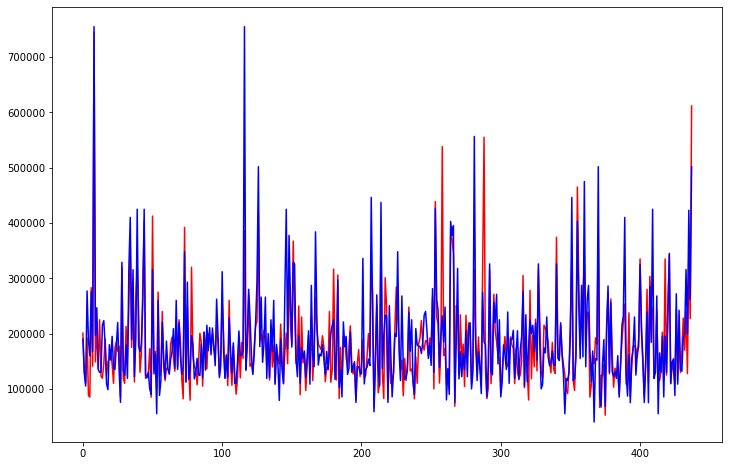

In [23]:
# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(y_test, color='red')
plt.plot(forest.predict(x_test), color='blue')
plt.show()

Now we can see the accuracy for training and test data.

In [29]:
predict = forest.predict(x_test)
accuracy = accuracy_score(y_test,predict)
print(f'Our training accuracy is {round(forest.score(x_train, y_train)*100,2)}%.')
print(f'Our test accuracy is {round(accuracy*100,2)}%.')

Our training accuracy is 76.61%.
Our test accuracy is 0.23%.


Almost 0% of accuracy using the test data. The model is incredible overfitted.

## Conclusions

So, why did the model turned out to be so bad? After this fiasco, I searched online to see what I did so wrong. To my surprised, every independent prediction model will have some level of overfitting with this dataset. For a decent final result, we must use multiple methods of prediction. But, since this is still a little bit beyond my reach, I'll leave it to my future self to try a better result with this dataset. 